# Single halo inference

In the case we are able to use the kinematic to isolate the star of a given dwarf galaxy, we can use CASBI also to make inference on a single dwarf galaxy. Let's begin by training.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
import torch

import os

from ili.validation.metrics import PosteriorCoverage
import CASBI.create_template_library as ctl
import CASBI.inference as inference
from CASBI.inference import CustomDataset_subhalo
from CASBI.utils.CNN import ConvNet_subhalo

2024-12-21 20:05:08.174350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734807908.193058 2251318 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734807908.198894 2251318 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 20:05:08.218100: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#path to the files generetated by the CASBI.preprocessing
data_path = "/export/data/vgiusepp/casbi_rewriting"

galaxy_file_path = os.path.join(data_path, "new_files/")
dataframe_path = os.path.join(data_path, "dataframe.parquet")
preprocessing_path = os.path.join(data_path, "preprocess_file.npz")

#generate template library
sigma = 0.
device = 'cuda'

template_library = ctl.TemplateLibrary(galaxy_file_path=galaxy_file_path, dataframe_path=dataframe_path, preprocessing_path=preprocessing_path, sigma=sigma)    
template_library.create_single_halo_library(test_percentage=0.1)

In [3]:
len(template_library.x_train)

3972

let's visualise a single galaxy chemical abundance

/tmp/ipykernel_2251318/1746697711.py:4: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(observable.T),


Text(0, 0.5, '[O/Fe]')

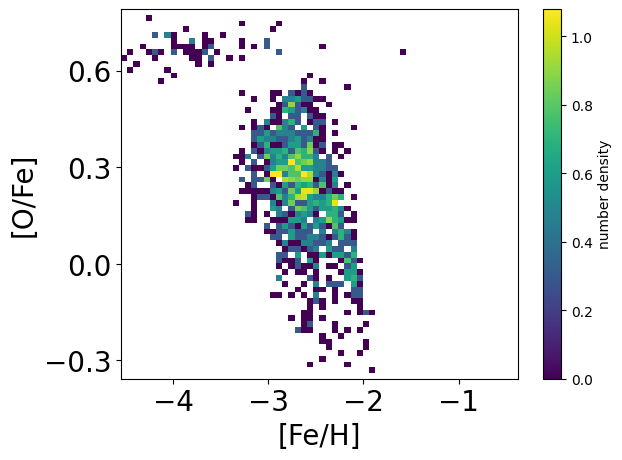

In [4]:
observable = template_library.x_train[2]

fig, ax = plt.subplots()
im = ax.imshow(np.log10(observable.T), 
           extent = [template_library.feh_lim[0], template_library.feh_lim[1], template_library.ofe_lim[0], template_library.ofe_lim[1]], 
           origin='lower', 
           cmap='viridis',
           aspect='auto')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('number density')

# Set the maximum number of ticks on the x and y axes to 4
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=4))


ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('[Fe/H]', fontsize=20)
ax.set_ylabel('[O/Fe]', fontsize=20)

In [5]:
x_train, params_train, x_test, params_test = template_library.get_inference_input()
x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)

/tmp/ipykernel_2251318/3894284057.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)
/tmp/ipykernel_2251318/3894284057.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)


In [8]:
#Inference
posterior_ensamble, summaries = inference.train_inference(x=x_train.to('cuda'), 
                                                          theta=params_train.to('cuda'), 
                                                          learning_rate=1e-4, 
                                                          N_nets=4,
                                                          hidden_feature=50,
                                                          num_transforms=5,
                                                          output_dir=f'./posterior/posterior_{sigma}', 
                                                          batch_size=256,
                                                          embedding_net= ConvNet_subhalo(output_dim=10),
                                                          custom_dataset = CustomDataset_subhalo,
                                                          device='cuda')


INFO:root:MODEL INFERENCE CLASS: NPE


INFO:root:Training model 1 / 2.


3972


96 epochs [00:18,  5.08 epochs/s, loss=-1.1, loss_val=-0.97]      
INFO:root:Training model 2 / 2.
167 epochs [00:33,  5.04 epochs/s, loss=-1.61, loss_val=-1.27]   
INFO:root:It took 52.090821504592896 seconds to train models.
INFO:root:Saving model to posterior/posterior_0.0


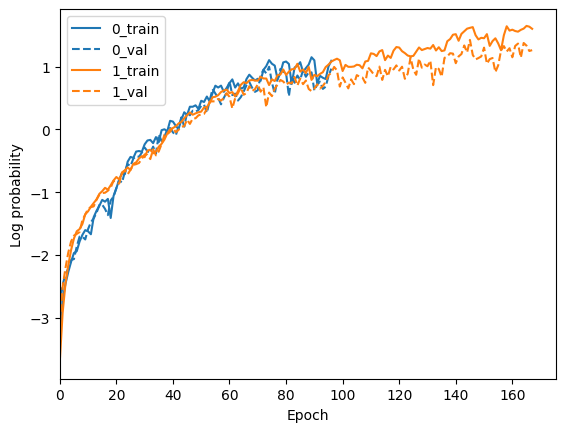

In [9]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, )
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

  0%|          | 2/442 [00:00<00:32, 13.63it/s]/export/home/vgiusepp/miniconda3/envs/fff/lib/python3.10/site-packages/ili/utils/ndes_pt.py:189: UserWarning: Direct sampling took too long. The posterior is poorly constrained within the prior support. Consider using emcee sampling or using a larger prior support. Returning prior samples.
  warnings.warn(
100%|██████████| 100/100 [00:03<00:00, 31.68it/s]


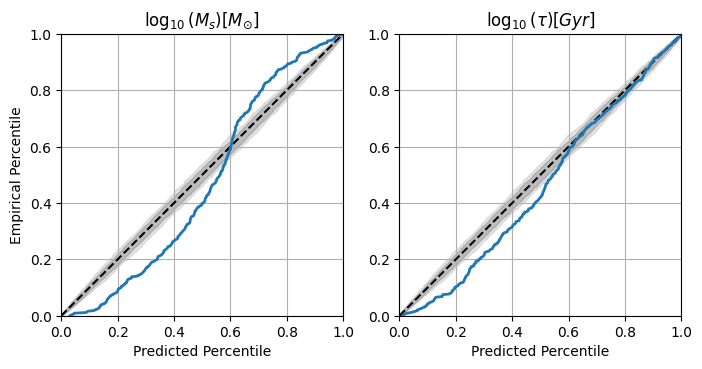

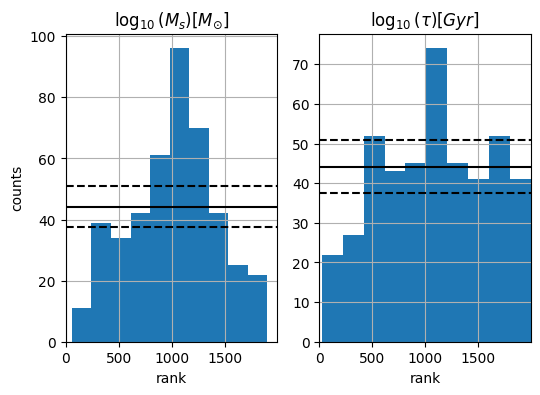

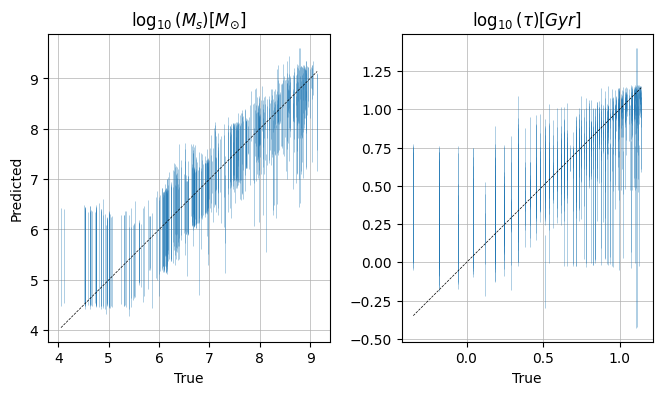

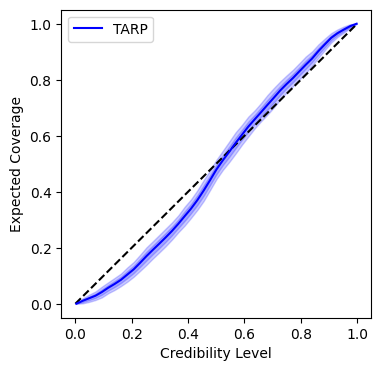

In [10]:
# x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)

plot_hist = ["coverage", "histogram", "predictions", "tarp"]
metric = PosteriorCoverage(
    num_samples=2_000, sample_method='direct',
    labels=[rf'$\log_{{10}}(M_{{s}}) [M_{{\odot}}]$', rf'$\log_{{10}}(\tau) [Gyr]$'], plot_list = plot_hist
)

fig = metric(
    posterior=posterior_ensamble,
    x=x_test, theta=params_test)